In [30]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchvision.datasets import *
from torch.optim import *
from torchvision.transforms import *
from collections import OrderedDict, defaultdict
from tqdm.auto import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train = CIFAR10(
    root="../cifar10/cifar10",
    train=True,
    download=False,
    transform=Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
  ]),
  )

test = CIFAR10(
    root="../cifar10/cifar10",
    train=False,
    download=False,
    transform=ToTensor()
  )

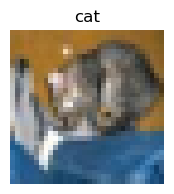

In [4]:
image, label = test[0]
plt.figure(figsize=(2, 2))
image = image.permute(1, 2, 0)

label = test.classes[label]

plt.imshow(image)
plt.title(label)
plt.axis("off")
plt.show()

In [ ]:
#https://arxiv.org/abs/1409.1556

In [44]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        ARCH = [64, 128, 'POOL', 256, 256, 'POOL', 512, 512, 'POOL', 512, 512, 'POOL'] #ARCH is autoregressive (predict future based on past) conditional heteroskedasticity
        #co is out channels, ci is in channels
        ci = 3 #RGB
        layers = []
        for x,co in enumerate(ARCH):
            if co != "POOL":
                layers.append(("conv"+str(x), nn.Conv2d(ci, co, 3, padding=1, bias=False))) #3 is kernel size kh=kw
                layers.append(("batch"+str(x),nn.BatchNorm2d(co)))
                layers.append(("relu"+str(x),nn.ReLU(True)))
                
                ci = co
            else:
                layers.append(("pool"+str(x),nn.MaxPool2d(2))) #max out of 2 by 2 so dim size goes down by half on width and height
                #number of channels and features doesn't change
        self.seq = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)
    def forward(self,x):
        x = self.seq(x)
        #avg pool
        x = x.mean([2,3]) #N, 512, 2 x 2 => N 512 by finding average
        x = self.classifier(x)
        return x


model = VGG()
                

In [45]:
train_dataloader = DataLoader(
    train,
    batch_size=512,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
  )

test_dataloader = DataLoader(
    test,
    batch_size=512,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
  )

In [46]:
optimizer = SGD(
  model.parameters(),
  lr=0.4,
  momentum=0.9,
  weight_decay=5e-4,
)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
model.train()
for epoch in range(10):
    for inputs,labels in tqdm(train_dataloader, desc = f'epoch {epoch}'):
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        print("loss",loss)
        print("percent correct", (outputs.argmax(dim=1)==labels).sum()/labels.size(0))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

loss tensor(2.3205, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1094)
loss tensor(2.3073, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1094)
loss tensor(2.3590, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1055)
loss tensor(2.3275, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1152)
loss tensor(2.2990, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1172)
loss tensor(2.2931, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1094)
loss tensor(2.3089, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1016)
loss tensor(2.2919, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1074)
loss tensor(2.2992, grad_fn=<NllLossBackward0>)
percent correct tensor(0.0781)
loss tensor(2.2799, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1113)
loss tensor(2.3085, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1250)
loss tensor(2.3238, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1133)
loss tensor(2.3264, grad_fn=<NllLossBackward0>)
perc

epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

loss tensor(2.2666, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1191)
loss tensor(2.2702, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1035)
loss tensor(2.2863, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1055)
loss tensor(2.2856, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1270)
loss tensor(2.2913, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1035)
loss tensor(2.2893, grad_fn=<NllLossBackward0>)
percent correct tensor(0.0898)
loss tensor(2.2766, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1230)
loss tensor(2.2865, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1191)
loss tensor(2.2751, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1074)
loss tensor(2.2588, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1309)
loss tensor(2.2583, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1055)
loss tensor(2.2585, grad_fn=<NllLossBackward0>)
percent correct tensor(0.1230)
loss tensor(2.2865, grad_fn=<NllLossBackward0>)
perc

In [51]:
num_samples = 0
num_correct = 0 

for inputs, labels in tqdm(test_dataloader, desc = f'epoch {epoch}'):
    model.eval()
    outputs = model(inputs)
    outputs = outputs.argmax(dim=1)
    num_samples += labels.size(0)
    num_correct += (outputs == labels).sum()

    print((num_correct / num_samples * 100))


epoch 0:   0%|          | 0/20 [00:00<?, ?it/s]

tensor(11.5234)
tensor(10.0586)
tensor(10.0260)
tensor(10.0098)
tensor(10.1562)
tensor(10.1562)
tensor(10.3795)
tensor(10.4736)
tensor(10.4601)
tensor(10.4688)
tensor(10.3161)
tensor(10.1725)
tensor(10.1412)
tensor(10.0167)
tensor(9.9349)
tensor(9.9976)
tensor(9.9035)
tensor(9.8741)
tensor(9.9507)
tensor(9.9500)
